In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/bodyPerformance.csv')
data = data.dropna()

In [4]:
data = pd.get_dummies(data, columns=['gender'], drop_first=True)

In [5]:
X = data.drop('class', axis=1)
y = data['class']

In [6]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
num_classes = len(np.unique(y))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
def train_multiclass_model(layers, activations, optimizer):
    model = Sequential()
    for i, (layer, activation) in enumerate(zip(layers, activations)):
        if i == 0:
            model.add(Dense(layer, activation=activation, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(layer, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, 
                        validation_data=(X_val, y_val), callbacks=
                        [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    return model, history

In [11]:
layer_options = [[16, 8], [32, 16], [64, 32]]
activation_options = [['relu', 'relu'], ['tanh', 'tanh'], ['relu', 'tanh']]
optimizer_options = ['adam', 'rmsprop', 'sgd']

In [12]:
multiclass_results = []

for layers in layer_options:
    for activations in activation_options:
        for optimizer in optimizer_options:
            model, history = train_multiclass_model(layers, activations, optimizer)
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)

            report = classification_report(y_test, y_pred_classes, output_dict=True)
            weighted_accuracy = report['accuracy']
            auc = roc_auc_score(y_test_categorical, y_pred, multi_class='ovr')

            multiclass_results.append({
                'layers': layers,
                'activations': activations,
                'optimizer': optimizer,
                'weighted_accuracy': weighted_accuracy,
                'auc': auc,
                'model': model,
                'history': history
            })

84/84 [==============================] - 0s 2ms/step


In [13]:
best_classifier = max(multiclass_results, key=lambda x: x['weighted_accuracy'])
print(f"The best classifier: layers {best_classifier['layers']}, activations {best_classifier['activations']}, optimizer {best_classifier['optimizer']}")
print(f"Weighted Accuracy: {best_classifier['weighted_accuracy']}")
print(f"AUC: {best_classifier['auc']}")

The best classifier: layers [64, 32], activations ['relu', 'relu'], optimizer adam
Weighted Accuracy: 0.7372153788727137
AUC: 0.9147190874186751


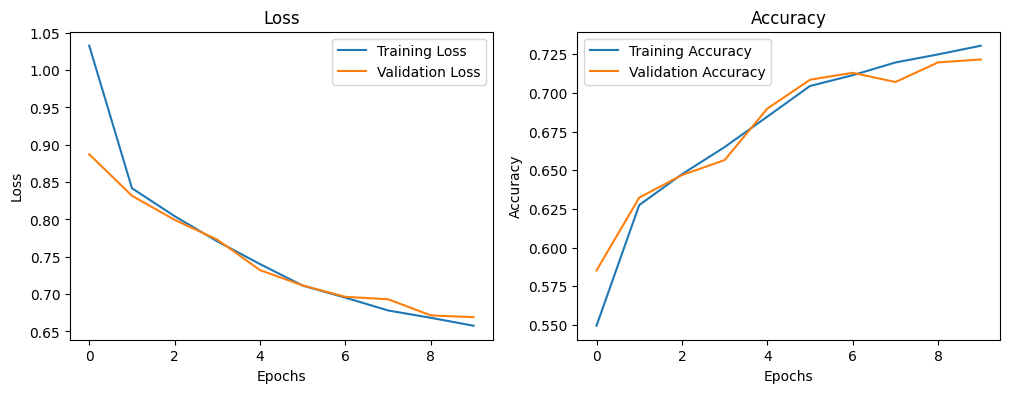

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_classifier['history'].history['loss'], label='Training Loss')
plt.plot(best_classifier['history'].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(best_classifier['history'].history['accuracy'], label='Training Accuracy')
plt.plot(best_classifier['history'].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

84/84 [==============================] - 0s 2ms/step


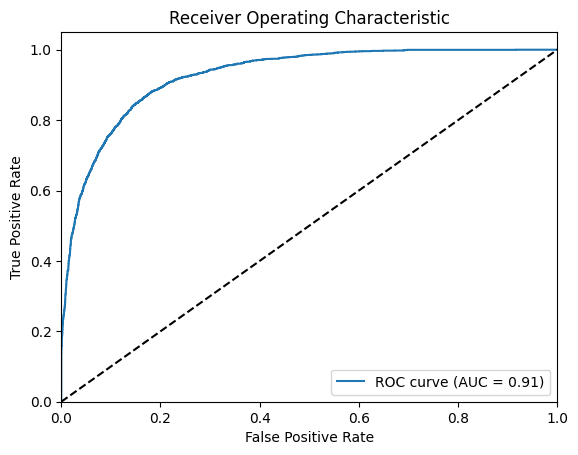

In [15]:
y_pred = best_classifier['model'].predict(X_test)
fpr, tpr, _ = roc_curve(y_test_categorical.ravel(), y_pred.ravel())
roc_auc = roc_auc_score(y_test_categorical, y_pred, multi_class='ovr')

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()